# SMLM Data Analysis - Tissues


## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import multiprocessing as mp
import pathlib as pl

import pandas as pd
import seaborn as sns

import scipy.stats as scs

import matplotlib.pyplot as plt

from smlm import helpers
from smlm import stats
from smlm import config as smlm_config
from smlm.styles import prism
from smlm.orte import Orte

prism.prism_style()


## Data selection

In [4]:
figure_base_size = smlm_config.FIG_BASE_SIZE
dpi = smlm_config.DPI
figure_file_type = smlm_config.FIG_TYPE
hue_method = smlm_config.TISSUE_HUE
density_col = smlm_config.LOG_NORM_DENS_COL
density_display = smlm_config.LOG_NORM_DENS_LABEL
stat = smlm_config.HIST_STAT

#############################################stage_method = "manual_5_stage"

result_dir = pl.Path("results/paper/fig6")
helpers.assure_dir(result_dir)

# labelling = "H2B_mCherry"
# # labelling = "SO_dissociated_neurons"
labelling = "SO_tissue"
# thunderstorm_param_1 = "1_0"
# # thunderstorm_param_1 = "0_7"
# thunderstorm_param_2 = "merge_filter"

data_dir = pl.Path("data/cut_cells/SO_tissue_170521")

# raw_orte_paths = [path for path in data_dir.glob(f"{labelling}/*/{thunderstorm_param_1}/{thunderstorm_param_2}/*.csv")]
raw_orte_paths = [path for path in data_dir.glob(f"**/*.csv")]
labelling_csv = pl.Path("data/cut_cells/SO_tissue_170521/tissue_cell_classification_070621.csv")

# cells_to_plot = ["recon_cell3_Nov7_thre0_7_merg_filt_cut.csv",
#                  "cell1_thre0_7_merg_filt_fram.csv",
#                  "",
#                  "cell4_tissue_thre0_7_recon_fram_merg_filt.csv",
#                  "cell2_thre0_7_nov10_merg_filt_cut.csv",
#                  "cell3_thre0_7_nov10_merg_filt_cut.csv"]



## Labelling

In [5]:
stages = pd.read_csv(labelling_csv)
stages = stages.assign(labelling=labelling)
stages["classification"] = stages.apply(helpers.get_tissue_label, axis=1)

## Orte Files

In [6]:
stages.file.to_list()
orte_paths = [raw_orte_path for raw_orte_path in raw_orte_paths if raw_orte_path.name in stages.file.to_list()]


## Calculating Voronoi tesselation and HDBSCAN clustering

In [7]:
# with mp.Pool(processes=1) as p:
with mp.Pool(processes=min(len(orte_paths), mp.cpu_count())) as p:
    orte_list = p.map(Orte, orte_paths, chunksize=1)

raw_all_cells = pd.DataFrame()
raw_all_clusters = pd.DataFrame()
for orte in orte_list:
    raw_all_cells = raw_all_cells.append(orte.orte_df)
    raw_all_clusters = raw_all_clusters.append(orte.get_named_cluster_meta())

del orte_list


In [8]:
all_cells = helpers.merge_localizations_stages(raw_all_cells, stages)
all_clusters = helpers.merge_localizations_stages(raw_all_clusters, stages)

In [9]:
del raw_all_cells
del raw_all_clusters

### Condensation / aCasp3

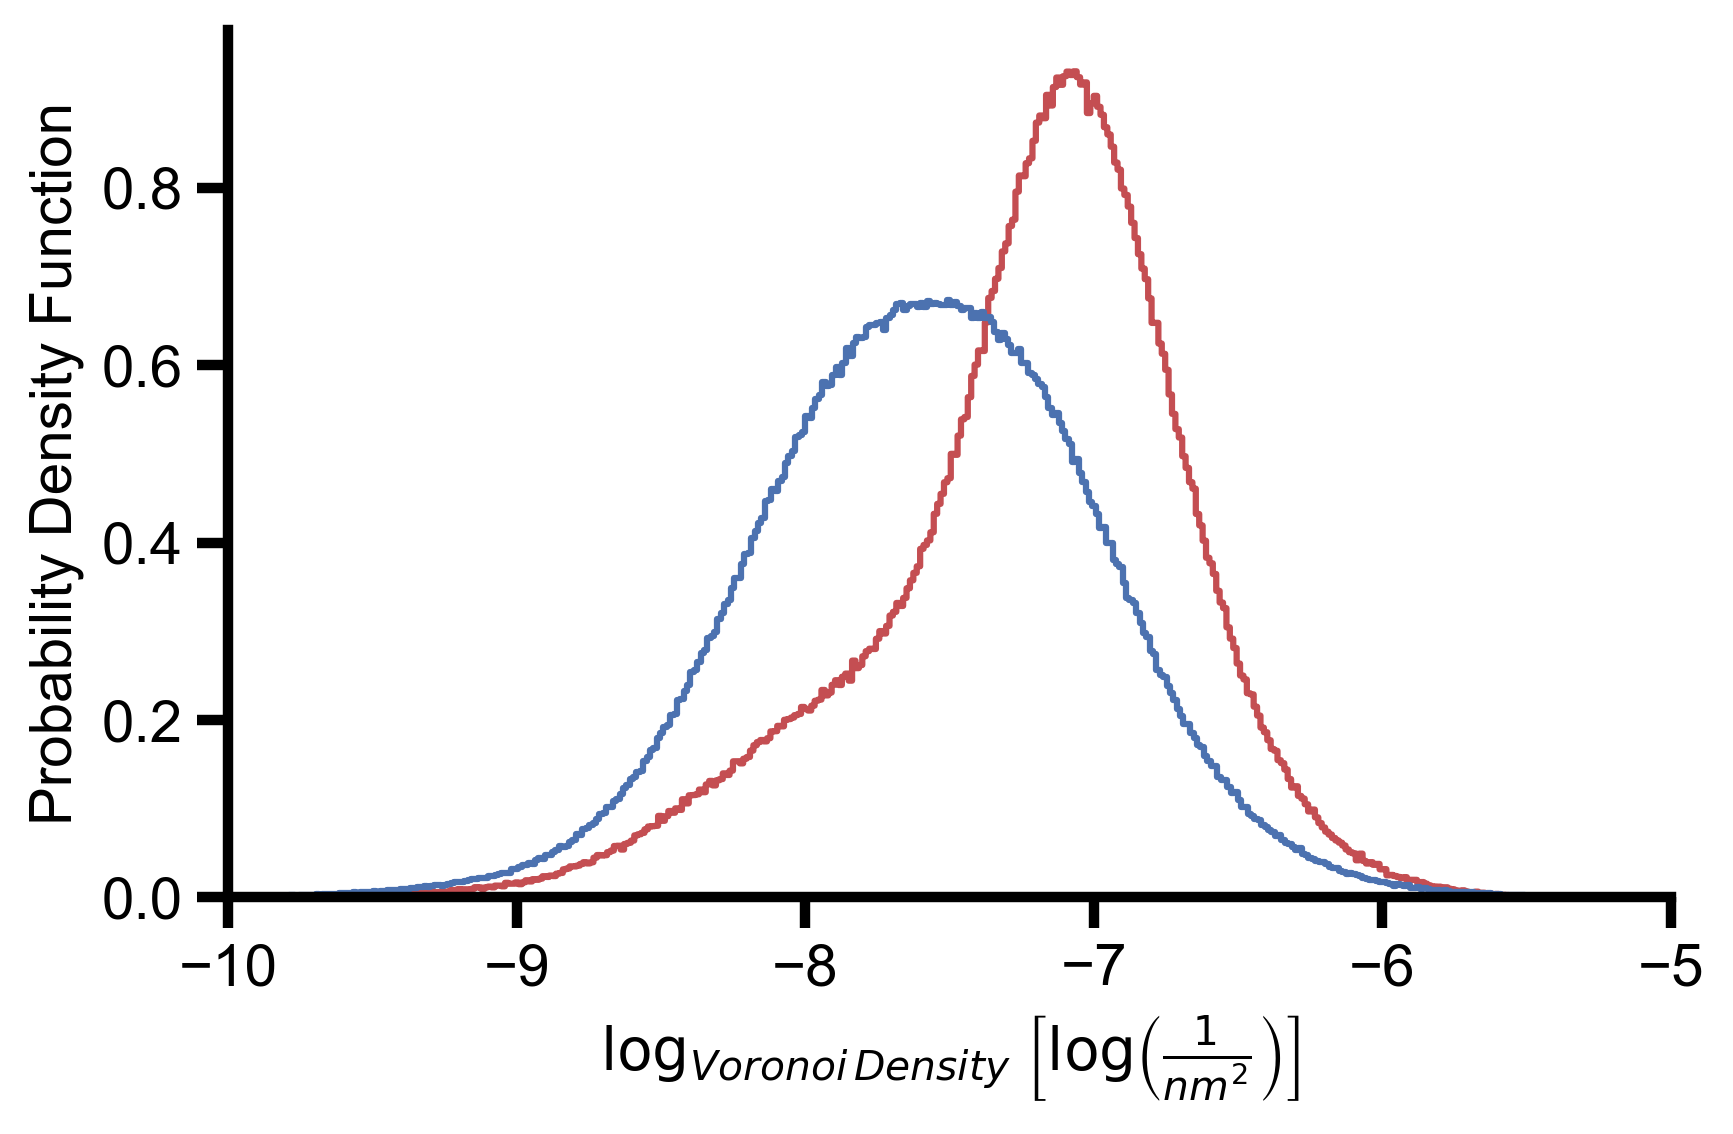

In [10]:
aCasp_fig, aCasp_ax = plt.subplots(dpi=dpi)
sns.histplot(x=density_col, hue=hue_method, data=all_cells,
             fill=False, element="step", stat=stat, common_norm=False, common_bins=False,
             palette=smlm_config.BIN_CMAP,
             legend=None,
             ax=aCasp_ax)

aCasp_ax.set_xlabel(density_display)
aCasp_ax.set_ylabel(smlm_config.PDF)
aCasp_ax.set_xlim(*smlm_config.DENSITY_LIM)

aCasp_fig.tight_layout()
aCasp_fig.savefig(result_dir.joinpath(f"voronoi_{density_col}_class.{figure_file_type}"))


In [11]:
stats.describe_hist_distribution(all_cells, density_col, hue_method).to_csv(result_dir.joinpath(f"voronoi_{density_col}_class.csv"))

In [12]:
statistic, p_val = scs.ranksums(x=all_cells.loc[all_cells[hue_method] == True][density_col],
                                y=all_cells.loc[all_cells[hue_method] == False][density_col])

stat_df = pd.DataFrame({"statistic": statistic, "p_val": p_val}, index=[0])
stat_df.to_csv(result_dir.joinpath(f"wilcoxon_rank_sums_{density_col}_{hue_method}.csv"), index=False, float_format="%1.10f")





